<a href="https://colab.research.google.com/github/renato747/Analise_de_Portefolio/blob/main/Carteira_Investimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de Portefólio de Instrumentos Financeiros detidos para Negociação**

## 1) Justo Valor

In [1]:
# Importar bibliotecas
import os
import pandas as pd
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf
import matplotlib.pyplot as plt
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Acessar os ficheiros através do Google Drive
drive.mount('/content/drive')

# Caminho da pasta que contém os ficheiros
folder_path = '/content/drive/My Drive/Investimentos II/Carteira/'

Mounted at /content/drive


In [3]:
# Função para extrair uma data no formato DD.MM.AAAA a partir do nome de um arquivo.
def extract_date_from_filename(filename):
    # Usa uma expressão regular (regex) para procurar o padrão de data no nome do arquivo.
    # O padrão (\d{2})\.(\d{2})\.(\d{4}) corresponde a:
    # - Dois dígitos (\d{2}) seguidos por um ponto (\.)
    # - Dois dígitos (\d{2}) seguidos por outro ponto (\.)
    # - Quatro dígitos (\d{4}) (ex.: "01.12.2023").
    match = re.search(r'(\d{2})\.(\d{2})\.(\d{4})', filename)

    # Se o padrão foi encontrado no nome do arquivo:
    if match:
        # Retorna a data formatada no padrão ISO (AAAA-MM-DD):
        # - group(3): o ano (AAAA)
        # - group(2): o mês (MM)
        # - group(1): o dia (DD)
        return f"{match.group(3)}-{match.group(2)}-{match.group(1)}"

    # Caso nenhuma data seja encontrada, retorna None.
    return None

# Gera uma lista de arquivos na pasta especificada (folder_path)
# que começam com 'Carteira' e terminam com '.xlsx' (arquivos Excel).
files = [f for f in os.listdir(folder_path) if f.startswith('Carteira') and f.endswith('.xlsx')]

# Exibe os nomes dos arquivos encontrados que atendem aos critérios.
print("Arquivos encontrados:", files)

Arquivos encontrados: ['Carteira 31.01.2023.xlsx', 'Carteira 28.02.2023.xlsx', 'Carteira 31.03.2023.xlsx', 'Carteira 30.04.2023.xlsx', 'Carteira 31.05.2023.xlsx', 'Carteira 30.06.2023.xlsx', 'Carteira 31.07.2023.xlsx', 'Carteira 31.08.2023.xlsx', 'Carteira 30.09.2023.xlsx', 'Carteira 31.10.2023.xlsx', 'Carteira 30.11.2023.xlsx', 'Carteira 31.12.2023.xlsx', 'Carteira 31.01.2024.xlsx', 'Carteira 29.02.2024.xlsx', 'Carteira 31.03.2024.xlsx', 'Carteira 30.04.2024.xlsx', 'Carteira 31.05.2024.xlsx', 'Carteira 30.06.2024.xlsx', 'Carteira 31.07.2024.xlsx', 'Carteira 31.08.2024.xlsx', 'Carteira 30.09.2024.xlsx', 'Carteira 31.10.2024.xlsx']


In [13]:
# Cria um DataFrame vazio para armazenar os dados consolidados de todos os arquivos Excel.
carteira_consolidada = pd.DataFrame()

# Itera sobre os arquivos Excel encontrados.
for file in files:
    file_path = os.path.join(folder_path, file)  # Caminho completo do arquivo.

    # Lê todas as planilhas do arquivo Excel.
    sheets = pd.read_excel(file_path, sheet_name=None)  # Retorna um dicionário {nome_da_planilha: DataFrame}.

    # Itera sobre cada planilha no arquivo.
    for sheet_name, df in sheets.items():
        # Extrai a data do nome do arquivo.
        date = extract_date_from_filename(file)

        # Adiciona a coluna 'Data' ao DataFrame da planilha.
        df['Data'] = date

        # Combina o DataFrame da planilha atual com o consolidado.
        carteira_consolidada = pd.concat([carteira_consolidada, df], ignore_index=True)

# Remove linhas que estão completamente vazias em todas as colunas.
carteira_consolidada.dropna(how='all', inplace=True)

# Converte a coluna Data para datetime do pandas
carteira_consolidada['Data'] = pd.to_datetime(carteira_consolidada['Data'], format='%Y-%m-%d')

# Filtra as linhas onde a coluna 'Código de Negociação' não é nula.
# Isso remove registros sem dados relevantes nesta coluna.
carteira_consolidada = carteira_consolidada[carteira_consolidada['Código de Negociação'].notna()]

# Define as colunas que serão mantidas no DataFrame final.
colunas_para_manter = ['Código de Negociação', 'Quantidade', 'Tipo', 'Preço de Fechamento', 'Valor Atualizado', 'Data']

# Filtra o DataFrame para manter apenas as linhas onde o valor na coluna 'Tipo' é 'Cotas' ou 'Recibo'.
# Além disso, restringe o DataFrame às colunas especificadas em `colunas_para_manter`.
carteira_consolidada = carteira_consolidada.loc[carteira_consolidada['Tipo'].isin(['Cotas', 'ON', 'PN']), colunas_para_manter]

# Dicionário de mapeamento de Código de Negociação para Segmento
segmento_mapeamento = {
    'MXRF11': 'Papéis',
    'XPML11': 'Shoppings',
    'KNCR11': 'Papéis',
    'XPLG11': 'Industrial e Logístico',
    'BRCO11': 'Industrial e Logístico',
    'RBRR11': 'Papéis',
    'KNRI11': 'Misto',
    'BTLG11': 'Industrial e Logístico',
    'BRCR11': 'Lajes corporativas',
    'XPIN11': 'Industrial e Logístico',
    'PVBI11': 'Lajes corporativas',
    'VINO11': 'Lajes corporativas',
    'BTAL11': 'Industrial e Logístico',
    'CMIG4': 'Energia Elétrica',
    'BBAS3': 'Banco',
    'CNES11': 'Lajes corporativas',
    'GOAU4': 'siderurgia e metalurgia'
}

# Cria a coluna "Segmento" usando o mapeamento
carteira_consolidada['Segmento'] = carteira_consolidada['Código de Negociação'].map(segmento_mapeamento)

In [14]:
# Identificar as linhas onde a coluna 'Segmento' é NaN
sem_segmento = carteira_consolidada[carteira_consolidada['Segmento'].isna()]

# Exibir os códigos de negociação sem segmento
print("Códigos de negociação sem segmento:")
print(sem_segmento['Código de Negociação'].unique())

Códigos de negociação sem segmento:
[]


In [16]:
# Agrupa os dados de 'Valor Atualizado' por mês e calcula a soma mensal.
# 1. Define a coluna 'Data' como índice do DataFrame (necessário para o método resample).
# 2. Resample aplica o agrupamento por frequência mensal ('M').
# 3. Soma os valores da coluna 'Valor Atualizado' para cada mês.
# 4. Reseta o índice para transformar o DataFrame em formato tabular novamente.
soma_mensal = carteira_consolidada.set_index('Data').resample('M')['Valor Atualizado'].sum().reset_index()

# Renomeia as colunas do DataFrame para 'Data' e 'Saldo Mensal'.
soma_mensal.columns = ['Data', 'Saldo Mensal']

# Adiciona uma nova coluna com o mês/ano formatado no formato 'MM/YYYY'.
# Usa dt.strftime para formatar a coluna 'Data' (que está no formato datetime).
soma_mensal['Mes_Ano Formatado'] = soma_mensal['Data'].dt.strftime('%m/%Y')

# Formata os valores de 'Saldo Mensal' como strings no formato brasileiro de moeda (ex.: 1.234,56).
# 1. Usa uma função lambda para aplicar formatação numérica com duas casas decimais.
# 2. Substitui pontos e vírgulas para atender ao formato brasileiro.
soma_mensal['Saldo Mensal Formatado'] = soma_mensal['Saldo Mensal'].apply(
    lambda x: f"{x:,.2f}".replace(",", "v").replace(".", ",").replace("v", ".")
)

# Cria um gráfico de barras utilizando o plotly express.
# Configura os eixos:
# - Eixo X: 'Mes_Ano Formatado' (Mês e Ano).
# - Eixo Y: 'Saldo Mensal' (soma do valor atualizado).
# Define também o título do gráfico e os rótulos dos eixos.
fig = px.bar(
    soma_mensal,
    x='Mes_Ano Formatado',
    y='Saldo Mensal',
    labels={'Mes_Ano Formatado': 'Mês/Ano', 'Saldo Mensal': 'Saldo Mensal (R$)'},
    title='Evolução da Carteira Consolidada'
)

# Atualiza os dados de hover (dica de ferramenta) do gráfico:
# 1. Mostra o Mês/Ano (Eixo X) e o Saldo Mensal formatado (R$ com casas decimais no formato brasileiro).
# 2. Define que a informação adicional mostrada será retirada do campo customdata.
fig.update_traces(
    hovertemplate='R$ %{customdata}<extra></extra>',
    customdata=soma_mensal['Saldo Mensal Formatado']
)

# Configura o formato dos ticks no eixo Y para incluir separadores de milhares.
fig.update_layout(yaxis_tickformat=',.0f')

# Exibe o gráfico gerado.
fig.show()

In [17]:
# Criar uma nova coluna categorizada com base no valor da coluna 'Tipo'.
# - Se 'Tipo' for "ON" ou "PN", categorizamos como "Ações".
# - Se 'Tipo' for "Cotas", categorizamos como "FIIs".
carteira_consolidada['Categoria'] = carteira_consolidada['Tipo'].apply(
    lambda x: 'Ações' if x in ['ON', 'PN'] else 'FIIs' if x == 'Cotas' else 'Outros'
)

# Agrupar os dados por Data e Categoria, e calcular o saldo mensal por categoria.
soma_mensal_categoria = (
    carteira_consolidada.groupby([pd.Grouper(key='Data', freq='M'), 'Categoria'])['Valor Atualizado']
    .sum()
    .reset_index()
)

# Adicionar uma coluna formatada para o mês/ano.
soma_mensal_categoria['Mes_Ano Formatado'] = soma_mensal_categoria['Data'].dt.strftime('%m/%Y')

# Criar o gráfico de barras empilhadas usando plotly express.
fig = px.bar(
    soma_mensal_categoria,
    x='Mes_Ano Formatado',
    y='Valor Atualizado',
    color='Categoria',  # Define as categorias (Ações e FIIs) como cores empilhadas.
    labels={'Mes_Ano Formatado': 'Mês/Ano', 'Valor Atualizado': 'Saldo (R$)', 'Categoria': 'Tipo'},
    title='Carteira Consolidada de Investimentos por Categoria'
)

# Personalizar o layout e dicas de ferramenta.
fig.update_traces(
    hovertemplate='R$ %{y:,.2f}<extra></extra>'
)

fig.update_layout(
    yaxis_tickformat=',.0f',  # Formato dos ticks do eixo Y.
    barmode='stack'  # Define que as barras são empilhadas.
)

# Exibir o gráfico.
fig.show()

In [ ]:
# Definindo a função 'criar_pivot' que recebe dois parâmetros:
# 'carteira_consolidada' - o DataFrame com os dados da carteira.
# 'valor' - a coluna do DataFrame a ser agregada na tabela dinâmica.
def criar_pivot(carteira, valor):
    # Retorna uma tabela dinâmica (pivot table) com base nos parâmetros fornecidos.
    # A tabela é agrupada por 'Código de Negociação' e tem uma coluna para cada data.
    # A agregação é feita pela soma dos valores especificados em 'valor'.
    # Caso algum valor esteja ausente, ele será preenchido com zero (fill_value=0).
    return carteira.pivot_table(index='Código de Negociação',    # Usando 'Código de Negociação' como índice (linhas).
                                           columns='Data',                 # Usando 'Data' como as colunas da tabela dinâmica.
                                           values=valor,                   # A coluna cujos valores serão somados (especificado pelo parâmetro 'valor').
                                           aggfunc='sum',                  # A função de agregação utilizada é a soma dos valores.
                                           fill_value=0)                   # Preenche os valores ausentes com zero.

In [ ]:
# Criar as pivots para a Carteira Consolidada
pivot_quantidade_consolidada = criar_pivot(carteira_consolidada, 'Quantidade')
pivot_preco_consolidada = criar_pivot(carteira_consolidada, 'Preço de Fechamento')
pivot_carteira_consolidada = criar_pivot(carteira_consolidada, 'Valor Atualizado')

# Filtrando os dados para Ações
carteira_acoes = carteira_consolidada[carteira_consolidada['Categoria'] == 'Ações']

# Criar as pivots para Ações
pivot_quantidade_acoes = criar_pivot(carteira_acoes, 'Quantidade')
pivot_preco_acoes = criar_pivot(carteira_acoes, 'Preço de Fechamento')
pivot_carteira_acoes = criar_pivot(carteira_acoes, 'Valor Atualizado')

# Filtrando os dados para FIIs
carteira_fiis = carteira_consolidada[carteira_consolidada['Categoria'] == 'FIIs']

# Criar as pivots para FIIs
pivot_quantidade_cotas = criar_pivot(carteira_fiis, 'Quantidade')
pivot_preco_cota = criar_pivot(carteira_fiis, 'Preço de Fechamento')
pivot_carteira_fiis = criar_pivot(carteira_fiis, 'Valor Atualizado')

**Consolidado:**

carteira_consolidada = dataframe que contém a consolidação de todos os ficheiros excel

pivot_quantidade_consolidada = contém a quantidade mensal de ações e cotas

pivot_preco_consolidada = contém o justo valor mensao por ação e por cota

pivot_carteira_consolidada = contém o justo valor mensal da carteira consolidada

**Ações:**

carteira_acoes = dataframe que contém apenas investimentos em ações

pivot_quantidade_acoes = contém a quantidade mensal de ações

pivot_preco_acoes = contém o justo valor mensal por de ação

pivot_carteira_acoes = contém o justo valor mensal da carteira de ações

**FIIS:**

carteira_fiis = dataframe que contém apenas investimentos em FIIS

pivot_quantidade_cotas = contém a quantidade mensal de cotas

pivot_preco_cota = contém o justo valor mensal por de cota

pivot_carteira_fiis = contém o justo valor mensal da carteira de fiis

## 2) Custo de Aquisição

In [ ]:
# Caminho onde os arquivos de Compra e Venda estão armazenados
folder_path_cv = '/content/drive/My Drive/Investimentos II/Extrato/'  # Altere para o caminho correto

In [ ]:
def carregar_arquivos_cv(folder_path_cv):
    """
    Carrega e consolida os dados de arquivos Excel de uma pasta específica, filtrando apenas as colunas relevantes.

    Argumentos:
    folder_path_cv (str): Caminho para a pasta contendo os arquivos Excel de entrada/saída (compra/venda).

    Retorna:
    pd.DataFrame: DataFrame consolidado com os dados relevantes de todos os arquivos encontrados.
    """
    # Listar todos os arquivos Excel na pasta especificada
    files_cv = [f for f in os.listdir(folder_path_cv) if f.endswith('.xlsx')]

    # Inicializar um DataFrame vazio para armazenar os dados consolidados
    extrato = pd.DataFrame()

    # Iterar sobre cada arquivo Excel na pasta
    for file in files_cv:
        # Obter o caminho completo do arquivo
        file_path = os.path.join(folder_path_cv, file)

        # Ler o conteúdo do arquivo Excel em um DataFrame
        df_cv = pd.read_excel(file_path)

        # Lista das colunas desejadas no DataFrame final
        colunas_para_manter_cv = [
            'Entrada/Saída',       # Indica se a operação foi de entrada (compra) ou saída (venda)
            'Movimentação',        # Indica se foi compra, venda de ativos ou recebimento de rendimentos
            'Data',                # Data da operação
            'Produto',             # Produto envolvido na operação
            'Quantidade',          # Quantidade comprada/vendida
            'Preço unitário',      # Preço por unidade do produto
            'Valor da Operação'    # Valor total da operação
        ]

        # Verificar quais colunas desejadas estão presentes no arquivo atual
        colunas_disponiveis = [col for col in colunas_para_manter_cv if col in df_cv.columns]

        # Filtrar o DataFrame para manter apenas as colunas disponíveis
        df_cv = df_cv[colunas_disponiveis]

        # Concatenar os dados do arquivo atual ao DataFrame consolidado
        extrato = pd.concat([extrato, df_cv], ignore_index=True)

    # Retornar o DataFrame consolidado com os dados de compra e venda
    return extrato

def processar_colunas(extrato):
    """
    Processa as colunas 'Produto' e 'Data' do DataFrame 'extrato', ajustando seus formatos
    e limpando linhas desnecessárias.

    Argumentos:
    extrato (pd.DataFrame): DataFrame contendo os dados de compra e venda.

    Retorna:
    pd.DataFrame: DataFrame processado com as colunas ajustadas e linhas inválidas removidas.
    """
    # Verificar e processar a coluna 'Data'
    if 'Data' in extrato.columns:
        # Converter a coluna 'Data' para o formato datetime, tratando erros como valores nulos (NaT)
        extrato['Data'] = pd.to_datetime(extrato['Data'], errors='coerce')

    # Verificar e processar a coluna 'Produto'
    if 'Produto' in extrato.columns:
        # Ajustar os valores da coluna 'Produto' para conter apenas os caracteres antes do primeiro espaço
        extrato['Produto'] = extrato['Produto'].astype(str).str.split().str[0]

    # Remover linhas que estão completamente vazias (todas as colunas NaN)
    extrato.dropna(how='all', inplace=True)

    # Retornar o DataFrame processado
    return extrato

def criar_coluna_data_mes(carteira_consolidada, extrato):
    """
    Adiciona uma coluna 'Data_Mes' nos DataFrames 'carteira_consolidada' e 'extrato',
    formatando as datas no estilo 'YYYY-MM' (ano e mês).

    Argumentos:
    carteira_consolidada (pd.DataFrame): DataFrame contendo os dados da carteira consolidada.
    extrato (pd.DataFrame): DataFrame contendo os dados de compras e vendas.

    Retorna:
    tuple: Uma tupla contendo os DataFrames 'carteira_consolidada' e 'extrato', ambos com a coluna 'Data_Mes' adicionada.
    """
    # Criar a coluna 'Data_Mes' no DataFrame 'carteira_consolidada'
    # Esta coluna extrai o ano e o mês da coluna 'Data' no formato 'YYYY-MM'
    carteira_consolidada['Data_Mes'] = carteira_consolidada['Data'].dt.strftime('%Y-%m')

    # Criar a mesma coluna 'Data_Mes' no DataFrame 'extrato'
    # Também no formato 'YYYY-MM', para facilitar comparações ou agrupamentos por período
    extrato['Data_Mes'] = extrato['Data'].dt.strftime('%Y-%m')

    # Retornar os dois DataFrames com as novas colunas
    return carteira_consolidada, extrato

def mapear_datas_para_mes(carteira_consolidada, extrato):
    """
    Ajusta as datas no DataFrame 'extrato' para corresponder às datas completas
    do DataFrame 'carteira_consolidada', utilizando a coluna 'Data_Mes' como referência.

    Argumentos:
    carteira_consolidada (pd.DataFrame): DataFrame contendo as datas completas e a coluna 'Data_Mes'.
    extrato (pd.DataFrame): DataFrame contendo a coluna 'Data_Mes' para ser ajustada.

    Retorna:
    pd.DataFrame: O DataFrame 'extrato' com as datas ajustadas na coluna 'Data_Mes'.
    """
    # Criar um dicionário para mapear os valores de 'Data_Mes' de 'carteira_consolidada' para suas datas completas.
    # - 'Data_Mes' é a chave, e a data completa (formato datetime.date) é o valor.
    mapa_datas = carteira_consolidada.set_index('Data_Mes')['Data'].dt.date.to_dict()

    # Ajustar a coluna 'Data_Mes' no DataFrame 'extrato' usando o dicionário de mapeamento.
    # - Substitui os valores de 'Data_Mes' em 'extrato' pelos valores completos de 'Data' correspondentes.
    extrato['Data_Mes'] = extrato['Data_Mes'].map(mapa_datas)

    # Retornar o DataFrame 'extrato' atualizado.
    return extrato

def classificar_produtos(extrato):
    """
    Adiciona uma coluna 'Categoria' ao DataFrame 'extrato' com base no número de caracteres da coluna 'Produto'.

    Regras:
    - Se o número de caracteres de 'Produto' for 5: Classificar como 'Ações'.
    - Se o número de caracteres de 'Produto' for 6: Classificar como 'FIIs'.
    - Caso contrário: Classificar como 'Outros'.

    Argumentos:
    extrato (pd.DataFrame): DataFrame contendo os dados de compra e venda.

    Retorna:
    pd.DataFrame: DataFrame com a nova coluna 'Categoria'.
    """
    if 'Produto' in extrato.columns:
        extrato['Categoria'] = extrato['Produto'].astype(str).apply(
            lambda x: 'Ações' if len(x) == 5 else 'FIIs' if len(x) == 6 else 'Outros'
        )
    else:
        raise ValueError("A coluna 'Produto' não está presente no DataFrame.")

    return extrato


def processar_dados(folder_path_cv, carteira_consolidada):
    """
    Processa os dados de Extrato e os integra com os dados da Carteira Consolidada.

    Argumentos:
    folder_path_cv (str): Caminho da pasta contendo os arquivos de Extrato.
    carteira_consolidada (pd.DataFrame): DataFrame contendo os dados da carteira consolidada.

    Retorna:
    pd.DataFrame: O DataFrame de Extrato processado, com as datas alinhadas ao formato da carteira consolidada.
    """
    # Etapa 1: Carregar os arquivos de Extrato
    # - Lê todos os arquivos Excel na pasta especificada e mantém apenas as colunas relevantes.
    extrato = carregar_arquivos_cv(folder_path_cv)

    # Etapa 2: Processar as colunas do DataFrame de Extrato
    # - Garante que as colunas 'Data' e 'Produto' sejam ajustadas conforme necessário.
    extrato = processar_colunas(extrato)

    # Etapa 3: Adicionar a classificação 'Ações', 'FIIs', ou 'Outros' baseada na coluna 'Produto'
    extrato = classificar_produtos(extrato)

    # Etapa 4: Criar a coluna 'Data_Mes' em ambos os DataFrames
    # - Adiciona a coluna 'Data_Mes' em 'carteira_consolidada' e 'extrato' no formato 'YYYY-MM'.
    carteira_consolidada, extrato = criar_coluna_data_mes(carteira_consolidada, extrato)

    # Etapa 5: Mapear as datas completas de 'carteira_consolidada' para 'extrato'
    # - Ajusta a coluna 'Data_Mes' em 'extrato' para corresponder às datas completas de 'carteira_consolidada'.
    extrato = mapear_datas_para_mes(carteira_consolidada, extrato)

    # Retorna o DataFrame de Extrato processado.
    return extrato

# Processar os dados
extrato = processar_dados(folder_path_cv, carteira_consolidada)

In [ ]:
#extrato.head()

In [ ]:
# Filtrar o extrato pelos movimentos de compra de ativos
extrato_compras_vendas = extrato[extrato['Movimentação'] == 'Transferência - Liquidação']

# Filtrar o extrato pelos movimentos de compra de ações
extrato_compras_acoes = extrato_compras_vendas[extrato_compras_vendas['Categoria'] == 'Ações']

# Filtrar o extrato pelos movimentos de compra de ações
extrato_compras_fiis = extrato_compras_vendas[extrato_compras_vendas['Categoria'] == 'FIIs']

In [ ]:
def calcular_preco_medio(extrato_compras_vendas):
    """
    Calcula o preço médio por cota com base no valor da operação e quantidade.
    """
    # Garantir que as colunas estejam no formato correto
    extrato_compras_vendas['Valor da Operação'] = pd.to_numeric(extrato_compras_vendas['Valor da Operação'], errors='coerce')
    extrato_compras_vendas['Quantidade'] = pd.to_numeric(extrato_compras_vendas['Quantidade'], errors='coerce')

    # Criar a pivot table: Produto como índice, e valores calculados
    pivot_preco_medio = extrato_compras_vendas.pivot_table(
        index='Produto',  # Definir Produto como índice
        values=['Valor da Operação', 'Quantidade'],  # Usar as colunas 'Valor da Operação' e 'Quantidade'
        aggfunc='sum',  # Agregar os valores pela soma
        fill_value=0  # Preencher valores ausentes com 0
    )

    # Calcular o valor médio: Valor da Operação / Quantidade
    pivot_preco_medio['Preço Médio'] = pivot_preco_medio['Valor da Operação'] / pivot_preco_medio['Quantidade']

    # Selecionar apenas a coluna do preço médio
    pivot_preco_medio_final = pivot_preco_medio[['Preço Médio']]

    # Preencher valores NaN com o último valor conhecido da mesma linha
    pivot_preco_medio_final['Preço Médio'] = pivot_preco_medio_final['Preço Médio'].fillna(method='pad')

    # Arredondar o preço médio para 2 casas decimais
    pivot_preco_medio_final = pivot_preco_medio_final.round(2)

    return pivot_preco_medio_final

def calcular_valor_investido(pivot_quantidade_consolidada, preco_medio_por_ativo):
    """
    Calcula o valor investido baseado na quantidade de cotas e no preço médio.
    """
    # Alinhar os índices para garantir que ambos têm a mesma estrutura para a multiplicação
    pivot_quantidade_alinhado = pivot_quantidade_consolidada.reindex(preco_medio_por_ativo.index)

    # Multiplicar cada coluna de pivot_quantidade_cotas pelo Preço Médio correspondente
    preco_medio_carteira = pivot_quantidade_alinhado.mul(preco_medio_por_ativo['Preço Médio'], axis=0)

    # Arredondar os valores
    preco_medio_carteira = preco_medio_carteira.round(2)

    return preco_medio_carteira

def calcular_variacao_percentual(preco_medio_por_ativo, pivot_quantidade_consolidada, pivot_preco_consolidada):
    """
    Calcula a variação percentual entre o preço médio e o preço de mercado, e calcula o saldo de mercado e preço médio.
    """
    # Obter as últimas colunas de quantidade de cotas e preço de cota
    ultima_data_qtd = pivot_quantidade_consolidada.columns[-1]
    ultima_data_preco = pivot_preco_consolidada.columns[-1]

    # Obter as quantidades e preços das últimas colunas e transformá-los em dicionários
    ultima_quantidade = pivot_quantidade_consolidada[ultima_data_qtd].to_dict()
    ultimo_preco = pivot_preco_consolidada[ultima_data_preco].to_dict()

    # Criar as novas colunas 'Qtde' e 'Preço Mercado' em 'preco_medio_por_ativo' baseadas nos mapeamentos
    preco_medio_por_ativo['Qtde'] = preco_medio_por_ativo.index.map(ultima_quantidade)
    preco_medio_por_ativo['Preço Mercado'] = preco_medio_por_ativo.index.map(ultimo_preco)

    # Calcular a variação percentual entre 'Preço Médio' e 'Preço Mercado'
    preco_medio_por_ativo['Variação (%)'] = ((preco_medio_por_ativo['Preço Mercado'] - preco_medio_por_ativo['Preço Médio'])
                                               / preco_medio_por_ativo['Preço Médio']) * 100

    # Calcular o valor investido e o valor de mercado
    preco_medio_por_ativo['Saldo Preço Médio'] = preco_medio_por_ativo['Qtde'] * preco_medio_por_ativo['Preço Médio']
    preco_medio_por_ativo['Saldo Preço Mercado'] = preco_medio_por_ativo['Qtde'] * preco_medio_por_ativo['Preço Mercado']

    # Reordenar as colunas para que 'Qtde' seja a primeira
    cols = ['Qtde'] + [col for col in preco_medio_por_ativo.columns if col != 'Qtde']
    preco_medio_por_ativo = preco_medio_por_ativo[cols]

    # Arredondar todas as colunas numéricas para duas casas decimais
    preco_medio_por_ativo = preco_medio_por_ativo.round(2)

    # Filtrar as linhas onde 'Qtde' é superior a zero
    preco_medio_por_ativo = preco_medio_por_ativo[preco_medio_por_ativo['Qtde'] > 0]

    return preco_medio_por_ativo

def gerar_grafico(preco_medio_carteira, pivot_carteira_consolidada, titulo='Desempenho Mensal do Portefólio de Investimento'):
    """
    Gera o gráfico de barras empilhadas sobre o valor investido e o valor de mercado da carteira.

    Argumentos:
    preco_medio_carteira (pd.DataFrame): DataFrame com os valores investidos ao longo do tempo.
    pivot_carteira_consolidada (pd.DataFrame): DataFrame com os valores de mercado ao longo do tempo.
    titulo (str): Título do gráfico. Padrão: 'Desempenho Mensal do Portefólio de Investimento'.
    """
    # Garantir que as colunas estejam no formato de data
    preco_medio_carteira.columns = pd.to_datetime(preco_medio_carteira.columns, format='%Y-%m-%d')
    pivot_carteira_consolidada.columns = pd.to_datetime(pivot_carteira_consolidada.columns, format='%Y-%m-%d')

    # Somar os valores mensais de todos os ativos
    total_valor_investido = preco_medio_carteira.sum(axis=0)  # Soma das colunas de cada mês
    total_valor_mercado = pivot_carteira_consolidada.sum(axis=0)  # Soma das colunas de cada mês

    # Calcular a mais/menos valia
    mais_menos_valia = total_valor_mercado - total_valor_investido

    # Calcular o valor patrimônio
    valor_patrimonio = total_valor_investido + mais_menos_valia

    # Criar um DataFrame consolidado para o gráfico
    df_consolidado = pd.DataFrame({
        'Data': total_valor_investido.index,
        'Valor Investido': total_valor_investido.values,
        'Mais/Menos Valia': mais_menos_valia.values,
        'Valor Patrimônio': valor_patrimonio.values
    })

    # Aplicar formatação brasileira
    def formatar_valor_brasileiro(row):
        valor_formatado = f"{row['Valor Investido']:,.2f}".replace(",", "v").replace(".", ",").replace("v", ".")
        mais_menos_valia_formatado = f"{row['Mais/Menos Valia']:,.2f}".replace(",", "v").replace(".", ",").replace("v", ".")
        valor_patrimonio_formatado = f"{row['Valor Patrimônio']:,.2f}".replace(",", "v").replace(".", ",").replace("v", ".")
        mes_ano_formatado = row['Data'].strftime('%m/%Y')
        return mes_ano_formatado, valor_formatado, mais_menos_valia_formatado, valor_patrimonio_formatado

    # Adicionar colunas formatadas ao DataFrame
    df_consolidado['Mes_Ano Formatado'], df_consolidado['Valor Investido Formatado'], df_consolidado['Mais/Menos Valia Formatado'], df_consolidado['Valor Patrimônio Formatado'] = zip(*df_consolidado.apply(formatar_valor_brasileiro, axis=1))

    # Criar o gráfico de barras empilhadas
    fig = px.bar(
        df_consolidado,
        x='Mes_Ano Formatado',
        y=['Valor Investido', 'Mais/Menos Valia'],
        labels={'variable': 'Tipo', 'value': 'Valor (R$)'},
        title=titulo  # Título personalizado
    )

    # Atualizar o hover template para incluir o Valor Patrimônio
    fig.update_traces(
        hovertemplate='%{x}<br>Valor Investido: R$ %{customdata[0]}<br>Mais/Menos Valia: R$ %{customdata[1]}<br>Valor Patrimônio: R$ %{customdata[2]}<extra></extra>',
        customdata=df_consolidado[['Valor Investido Formatado', 'Mais/Menos Valia Formatado', 'Valor Patrimônio Formatado']].values
    )

    # Configurar o layout do gráfico
    fig.update_layout(
        barmode='relative',  # Para barras empilhadas
        yaxis_tickformat=',.0f',  # Formatação do eixo Y
        xaxis_title='',  # Remove o título do eixo X
        xaxis=dict(
            tickmode='array',
            tickvals=df_consolidado['Mes_Ano Formatado'],
            ticktext=df_consolidado['Mes_Ano Formatado']
        )
    )

    return fig

def processar_carteira(extrato, pivot_quantidade, pivot_preco, pivot_carteira, titulo):
    """
    Processa uma carteira de investimentos, calculando o preço médio, variação percentual,
    valor investido e gera um gráfico.

    Args:
    extrato (pd.DataFrame): Extrato de compras e vendas.
    pivot_quantidade (pd.DataFrame): Quantidades consolidadas.
    pivot_preco (pd.DataFrame): Preços consolidados.
    pivot_carteira (pd.DataFrame): Carteira consolidada.
    titulo (str): Título do gráfico gerado.

    Returns:
    dict: Contém os DataFrames intermediários e o gráfico.
    """
    # Calcular o preço médio por ativo
    preco_medio_por_ativo = calcular_preco_medio(extrato)

    # Atualizar o DataFrame com variações, quantidade, saldos e preço de mercado
    preco_medio_por_ativo = calcular_variacao_percentual(preco_medio_por_ativo, pivot_quantidade, pivot_preco)

    # Calcular o valor total investido na carteira
    preco_medio_carteira = calcular_valor_investido(pivot_quantidade, preco_medio_por_ativo)

    # Gerar o gráfico
    figura = gerar_grafico(preco_medio_carteira, pivot_carteira, titulo=titulo)

    # Retornar os resultados
    return {
        "preco_medio_por_ativo": preco_medio_por_ativo,
        "preco_medio_carteira": preco_medio_carteira,
        "grafico": figura
    }

In [ ]:
# Carteira Consolidada
evolucao_carteira_consolidada = processar_carteira(
    extrato=extrato_compras_vendas,
    pivot_quantidade=pivot_quantidade_consolidada,
    pivot_preco=pivot_preco_consolidada,
    pivot_carteira=pivot_carteira_consolidada,
    titulo="Evolução da Carteira Consolidada"
)
evolucao_carteira_consolidada["grafico"].show()

# Carteira de Ações
evolucao_carteira_acoes = processar_carteira(
    extrato=extrato_compras_acoes,
    pivot_quantidade=pivot_quantidade_acoes,
    pivot_preco=pivot_preco_acoes,
    pivot_carteira=pivot_carteira_acoes,
    titulo="Evolução da Carteira de Ações"
)
evolucao_carteira_acoes["grafico"].show()

# Carteira de FIIs
evolucao_carteira_fiis = processar_carteira(
    extrato=extrato_compras_fiis,
    pivot_quantidade=pivot_quantidade_cotas,
    pivot_preco=pivot_preco_cota,
    pivot_carteira=pivot_carteira_fiis,
    titulo="Evolução da Carteira de FIIs"
)
evolucao_carteira_fiis["grafico"].show()

Código para gráfico de pizza

In [ ]:
"""
O código abaixo é utilizado para gerar gráfico de anel (doughnut chart)

"""
# Calcula o preço médio das ações com base no extrato de compras.
preco_medio_acoes = calcular_preco_medio(extrato_compras_acoes)

# Atualiza o DataFrame de preço médio das ações, adicionando a variação percentual
# a partir das informações de quantidade e preço (pivot).
preco_medio_acoes = calcular_variacao_percentual(preco_medio_acoes, pivot_quantidade_acoes, pivot_preco_acoes)

# Calcula o preço médio dos FIIs (Fundos de Investimento Imobiliário) com base no extrato de compras.
preco_medio_fiis = calcular_preco_medio(extrato_compras_fiis)

# Atualiza o DataFrame de preço médio dos FIIs, adicionando a variação percentual
# com base nas informações de quantidade de cotas e preço das cotas (pivot).
preco_medio_fiis = calcular_variacao_percentual(preco_medio_fiis, pivot_quantidade_cotas, pivot_preco_cota)

# Calcula o preço médio consolidado (ações + FIIs) com base no extrato consolidado de compras e vendas.
preco_medio_consolidada = calcular_preco_medio(extrato_compras_vendas)

# Atualiza o DataFrame consolidado, adicionando a variação percentual
# com base nas informações consolidadas de quantidade e preço.
preco_medio_consolidada = calcular_variacao_percentual(preco_medio_consolidada, pivot_quantidade_consolidada, pivot_preco_consolidada)

In [ ]:
def gerar_grafico_anual(preco_medio_df, titulo):
    """
    Gera um gráfico de anel (doughnut chart) para os dados de um DataFrame sem modificar o original.

    Args:
    preco_medio_df (pd.DataFrame): DataFrame contendo informações de saldo de mercado e valor investido.
    titulo (str): Título do gráfico.

    Returns:
    plotly.graph_objs._figure.Figure: Objeto do gráfico gerado.
    """
    # Criar uma cópia do DataFrame para não alterar o original
    df_temp = preco_medio_df.copy()

    # Função para formatar os valores no estilo brasileiro
    def formatar_valor_brasileiro(valor):
        return f"R$ {valor:,.2f}".replace(",", "v").replace(".", ",").replace("v", ".")

    # Aplicar a formatação brasileira para Saldo Preço Mercado e Saldo Preço Médio
    df_temp['Saldo Preço Mercado Formatado'] = df_temp['Saldo Preço Mercado'].apply(formatar_valor_brasileiro)
    df_temp['Saldo Preço Médio Formatado'] = df_temp['Saldo Preço Médio'].apply(formatar_valor_brasileiro)

    # Calcular a diferença entre Valor de Mercado e Valor Investido
    df_temp['Diferença Mercado Investido'] = (
        df_temp['Saldo Preço Mercado'] - df_temp['Saldo Preço Médio']
    )

    # Aplicar a formatação brasileira na diferença calculada
    df_temp['Diferença Mercado Investido Formatada'] = df_temp['Diferença Mercado Investido'].apply(formatar_valor_brasileiro)

    # Calcular a variação percentual (Preço Mercado / Preço Médio - 1)
    df_temp['Percentual Mais/Menos Valia'] = (
        (df_temp['Saldo Preço Mercado'] / df_temp['Saldo Preço Médio'] - 1) * 100
    )

    # Formatar a variação percentual com 2 casas decimais e símbolo de porcentagem
    df_temp['Percentual Mais/Menos Valia Formatado'] = df_temp['Percentual Mais/Menos Valia'].apply(
        lambda x: f"{x:.2f}%"
    )

    # Resetar o índice para garantir que 'Produto' seja uma coluna
    df_temp = df_temp.reset_index()

    # Criar a coluna de customdata com as informações de "Saldo Preço Mercado", "Saldo Preço Médio", a diferença e a percentagem
    df_temp['Customdata'] = [
        f"Justo Valor: {valor_mercado}<br>Custo Médio: {preco_medio}<br>Ganho/Perda de capital: {diferenca}<br>Ganho/Perda de capital em %: {percentual}"
        for valor_mercado, preco_medio, diferenca, percentual in zip(
            df_temp['Saldo Preço Mercado Formatado'],
            df_temp['Saldo Preço Médio Formatado'],
            df_temp['Diferença Mercado Investido Formatada'],
            df_temp['Percentual Mais/Menos Valia Formatado']
        )
    ]

    # Criar o gráfico de anel (doughnut chart) usando plotly express
    fig = px.pie(df_temp,
                 values='Saldo Preço Mercado',  # Usar a coluna de valores
                 names='Produto',  # Nome dos ativos
                 title=titulo,  # Título do gráfico
                 hole=0.4,  # Criar o gráfico de anel
                 width=800,   # Largura do gráfico em pixels
                 height=600)  # Altura do gráfico em pixels

    # Centralizar o título do gráfico
    fig.update_layout(
        title={'text': titulo, 'x': 0.5, 'xanchor': 'center'},
        showlegend=False  # Exibir a legenda para os ativos
    )

    # Personalizar o estilo de hover (ao passar o cursor)
    fig.update_traces(
        hovertemplate='%{label}<br>%{customdata}<extra></extra>',  # Exibe as informações do hover
        textinfo='label+percent',  # Mostrar o nome do ativo e percentagem no gráfico
        textposition='outside',  # Colocar o texto fora das fatias
        insidetextorientation='radial',  # Orientação radial do texto dentro das fatias
        customdata=df_temp['Customdata']  # Usar a coluna customizada para hover
    )

    return fig

In [ ]:
# Gráfico para a carteira consolidada
fig_consolidada = gerar_grafico_anual(preco_medio_consolidada, titulo="Carteira Consolidada")
fig_consolidada.show()

# Gráfico para a carteira de ações
fig_acoes = gerar_grafico_anual(preco_medio_acoes, titulo="Carteira de Ações")
fig_acoes.show()

# Gráfico para a carteira de FIIs
fig_fiis = gerar_grafico_anual(preco_medio_fiis, titulo="Carteira de FIIs")
fig_fiis.show()

In [ ]:
preco_medio_acoes.head()

,Qtde,Preço Médio,Preço Mercado,Variação (%),Saldo Preço Médio,Saldo Preço Mercado
Produto,,,,,,
BBAS3,400.0,27.08,26.33,-2.77,10832.0,10532.0
CMIG4,910.0,10.40,11.37,9.33,9464.0,10346.7
GOAU4,700.0,10.66,10.27,-3.66,7462.0,7189.0


In [ ]:
preco_medio_fiis.head()

,Qtde,Preço Médio,Preço Mercado,Variação (%),Saldo Preço Médio,Saldo Preço Mercado
Produto,,,,,,
BRCO11,167.0,118.82,107.88,-9.21,19842.94,18015.96
BRCR11,152.0,68.78,43.50,-36.75,10454.56,6612.00
BTLG11,141.0,95.71,96.03,0.33,13495.11,13540.23
KNCR11,188.0,97.38,104.52,7.33,18307.44,19649.76
KNRI11,90.0,158.61,138.30,-12.80,14274.90,12447.00


In [ ]:
preco_medio_consolidada.head()

,Qtde,Preço Médio,Preço Mercado,Variação (%),Saldo Preço Médio,Saldo Preço Mercado
Produto,,,,,,
BBAS3,400.0,27.08,26.33,-2.77,10832.00,10532.00
BRCO11,167.0,118.82,107.88,-9.21,19842.94,18015.96
BRCR11,152.0,68.78,43.50,-36.75,10454.56,6612.00
BTLG11,141.0,95.71,96.03,0.33,13495.11,13540.23
CMIG4,910.0,10.40,11.37,9.33,9464.00,10346.70


**Consolidado:**

extrato_compras_vendas = contém todos os movimentos (compras, vendas, direito, rendimentos, etc)

preco_medio_por_ativo = contém o custo médio de aquisição e outras informações

preco_medio_carteira = contém o custo médio de aquisição da carteira

evolucao_carteira_consolidada = gráfico com a evolução do valor patrimonial (sem dividendos)


**Ações:**

extrato_compras_acoes = contém todos os movimentos de ações

preco_medio_por_acao = contém o custo médio por ação

preco_medio_carteira_acoes = contém o custo médio da carteira de ações

evolucao_carteira_acoes = gráfico com a evolução do valor patrimonial da carteira de ações (sem dividendos)


**FIIS:**

extrato_compras_fiis = contém todos os movimentos de fiis

preco_medio_por_fii = contém o custo médio por fii

preco_medio_carteira_fiis = contém o custo médio da carteira de fiis

evolucao_carteira_fiis = gráfico com a evolução do valor patrimonial da carteira de FIIs (sem rendimentos)



In [ ]:
'''# Caminho no Google Drive
caminho_drive = '/content/drive/My Drive/extrato.xlsx'

# Salvar no Google Drive
extrato.to_excel(caminho_drive, index=False)
print(f"Arquivo salvo no Google Drive: {caminho_drive}")'''

'# Caminho no Google Drive\ncaminho_drive = \'/content/drive/My Drive/extrato.xlsx\'\n\n# Salvar no Google Drive\nextrato.to_excel(caminho_drive, index=False)\nprint(f"Arquivo salvo no Google Drive: {caminho_drive}")'

## 3) Rendimentos Recebidos

In [ ]:
# Filtrar as movimentações específicas na coluna 'Movimentação'
rendimentos_consolidado = extrato[extrato['Movimentação'].isin(['Rendimento', 'Dividendo', 'Juros Sobre Capital Próprio'])]

In [ ]:
rendimentos_consolidado.head()

,Entrada/Saída,Movimentação,Data,Produto,Quantidade,Preço unitário,Valor da Operação,Categoria,Data_Mes
2,Credito,Rendimento,2023-02-24,BTLG11,63,0.74,46.62,FIIs,2023-02-28
5,Credito,Rendimento,2023-02-14,VINO11,60,0.31,18.6,FIIs,2023-02-28
6,Credito,Rendimento,2023-02-13,KNCR11,5,1.2,6.0,FIIs,2023-02-28
7,Credito,Rendimento,2023-02-07,PVBI11,1,0.61,0.61,FIIs,2023-02-28
11,Credito,Rendimento,2023-03-24,BTLG11,63,0.74,46.62,FIIs,2023-03-31


In [ ]:
'''
Função para criar gráficos de rendimento consolidado da carteira e por categoria

'''
# Função para formatar os valores no estilo brasileiro
def formatar_brasileiro(valor):
    return f"R$ {valor:,.2f}".replace(",", "v").replace(".", ",").replace("v", ".")

# Função para processar os rendimentos
def processar_rendimentos(dataframe, categorias=None):
    """
    Filtra, processa e retorna os rendimentos consolidados de acordo com as categorias especificadas.

    :param dataframe: DataFrame com os dados do extrato.
    :param categorias: Lista de categorias para filtrar (e.g., ['Ações', 'FIIs']). Se None, considera todas.
    :return: DataFrame consolidado por mês, com rendimentos mensais e acumulados.
    """
    # Filtrar movimentações relevantes
    rendimentos_consolidado = dataframe[
        dataframe['Movimentação'].isin(['Rendimento', 'Dividendo', 'Juros Sobre Capital Próprio'])
    ]


    # Filtrar categorias específicas, se fornecido
    if categorias:
        rendimentos_consolidado = rendimentos_consolidado[rendimentos_consolidado['Categoria'].isin(categorias)]

    # Garantir que a coluna de datas esteja no formato datetime
    rendimentos_consolidado['Data'] = pd.to_datetime(rendimentos_consolidado['Data'], format='%Y-%m-%d')

    # Agrupar por mês e somar os valores
    rendimentos_mensais = rendimentos_consolidado.set_index('Data').resample('M')['Valor da Operação'].sum().reset_index()

    # Renomear as colunas
    rendimentos_mensais.columns = ['Data', 'Rendimentos Mensais']

    # Criar uma coluna para o formato de Mês/Ano
    rendimentos_mensais['Mes_Ano Formatado'] = rendimentos_mensais['Data'].dt.strftime('%m/%Y')

    # Calcular os rendimentos acumulados
    rendimentos_mensais['Rendimentos Acumulados'] = rendimentos_mensais['Rendimentos Mensais'].cumsum()

    # Criar colunas formatadas para os valores mensais e acumulados
    rendimentos_mensais['Rendimentos Mensais Formatado'] = rendimentos_mensais['Rendimentos Mensais'].apply(formatar_brasileiro)
    rendimentos_mensais['Rendimentos Acumulados Formatado'] = rendimentos_mensais['Rendimentos Acumulados'].apply(formatar_brasileiro)

    return rendimentos_mensais

# Função para gerar gráficos
def gerar_graficos(rendimentos_mensais, titulo_mensal, titulo_acumulado):
    """
    Gera gráficos de rendimentos mensais e acumulados a partir de um DataFrame processado.

    :param rendimentos_mensais: DataFrame com os rendimentos mensais processados.
    :param titulo_mensal: Título do gráfico de rendimentos mensais.
    :param titulo_acumulado: Título do gráfico de rendimentos acumulados.
    :return: Figuras do Plotly (mensal, acumulado).
    """
    # Gráfico de rendimentos mensais
    fig_mensal = px.bar(
        rendimentos_mensais,
        x='Mes_Ano Formatado',
        y='Rendimentos Mensais',
        labels={'Mes_Ano Formatado': 'Mês/Ano', 'Rendimentos Mensais': 'Rendimentos Mensais (R$)'},
        title=titulo_mensal
    )
    fig_mensal.update_traces(
        hovertemplate='%{x}<br>Rendimentos: %{customdata}<extra></extra>',
        customdata=rendimentos_mensais['Rendimentos Mensais Formatado']
    )
    fig_mensal.update_layout(yaxis_tickformat=',.0f')

    # Gráfico de rendimentos acumulados
    fig_acumulado = px.bar(
        rendimentos_mensais,
        x='Mes_Ano Formatado',
        y='Rendimentos Acumulados',
        labels={'Mes_Ano Formatado': 'Mês/Ano', 'Rendimentos Acumulados': 'Rendimentos Acumulados (R$)'},
        title=titulo_acumulado
    )
    fig_acumulado.update_traces(
        hovertemplate='%{x}<br>Rendimentos Acumulados: %{customdata}<extra></extra>',
        customdata=rendimentos_mensais['Rendimentos Acumulados Formatado']
    )
    fig_acumulado.update_layout(yaxis_tickformat=',.0f')

    return fig_mensal, fig_acumulado

# Processar rendimentos gerais
rendimentos_gerais = processar_rendimentos(dataframe=extrato)

# Processar rendimentos para FIIs
rendimentos_fiis = processar_rendimentos(dataframe=extrato, categorias=['FIIs'])

# Processar rendimentos para Ações
rendimentos_acoes = processar_rendimentos(dataframe=extrato, categorias=['Ações'])

# Gerar gráficos consolidados
fig_consolidado_mensal, fig_consolidado_acumulado = gerar_graficos(
    rendimentos_gerais,
    titulo_mensal='Rendimento Mensal - Carteira Consolidada',
    titulo_acumulado='Rendimento Acumulado - Carteira Consolidada'
)

# Gerar gráficos para FIIs
fig_fiis_mensal, fig_fiis_acumulado = gerar_graficos(
    rendimentos_fiis,
    titulo_mensal='Rendimento Mensal - Carteira de FIIs',
    titulo_acumulado='Rendimento Acumulado - Carteira de FIIs'
)

# Gerar gráficos para Ações
fig_acoes_mensal, fig_acoes_acumulado = gerar_graficos(
    rendimentos_acoes,
    titulo_mensal='Rendimento Mensal - Carteira de Ações',
    titulo_acumulado='Rendimento Acumulado - Carteira de Ações'
)

# Mostrar os gráficos
fig_consolidado_mensal.show()
fig_consolidado_acumulado.show()
fig_fiis_mensal.show()
fig_fiis_acumulado.show()
fig_acoes_mensal.show()
fig_acoes_acumulado.show()

In [ ]:
'''
Função para criar gráficos de rendimento por Ativo

'''
# Função para formatar a coluna Data_Mes no estilo MM/AAAA
def formatar_data_mes(data_mes):
    """
    Converte uma data no formato '%Y-%m' para o formato 'MM/AAAA'.
    """
    return pd.to_datetime(data_mes, format='%Y-%m').strftime('%m/%Y')

# Função para formatar valores monetários no estilo brasileiro (ex: R$ 1.234,56)
def formatar_valor_brasileiro(valor):
    """
    Converte um número para o formato monetário brasileiro, com símbolo "R$" e separadores de milhar e decimal.
    """
    return f'R$ {valor:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')

# Função para criar o gráfico de barras para um produto específico
def criar_grafico_barras_produto(pivot_rendimentos, pivot_quantidade, produto):
    """
    Gera o gráfico de barras para um produto específico com dados de rendimentos e quantidade.

    :param pivot_rendimentos: Pivot table de rendimentos (index='Produto', columns='Data_Mes').
    :param pivot_quantidade: Pivot table de quantidade (index='Produto', columns='Data_Mes').
    :param produto: Nome do produto para o qual gerar o gráfico.
    :return: Figura do gráfico Plotly.
    """
    # Obter dados do produto
    dados_produto = pivot_rendimentos.loc[produto]
    quantidades_produto = pivot_quantidade.loc[produto]

    # Formatar dados
    datas_formatadas = [formatar_data_mes(data_mes) for data_mes in dados_produto.index]
    valores_formatados = [formatar_valor_brasileiro(valor) for valor in dados_produto.values]
    valores_acumulados = dados_produto.cumsum()
    valores_acumulados_formatados = [formatar_valor_brasileiro(valor) for valor in valores_acumulados]

    # Criar gráfico de barras
    fig = px.bar(
        x=datas_formatadas,
        y=dados_produto.values,
        labels={'x': 'Mês/Ano', 'y': 'Rendimentos Mensais (R$)'},
        title=f'Rendimentos Mensais do Produto: {produto}'
    )

    # Adicionar hover personalizado
    fig.update_traces(
        hovertemplate=(
            '%{x}<br>Rendimento do mês: %{customdata[0]}<br>'
            'Rendimento acumulado: %{customdata[1]}<br>'
            'Qtde de cotas que receberam rendimentos: %{customdata[2]}<extra></extra>'
        ),
        customdata=list(zip(valores_formatados, valores_acumulados_formatados, quantidades_produto.values))
    )

    # Configuração adicional do layout
    fig.update_layout(
        yaxis_tickformat=',.0f',  # Formato de números no eixo Y
        xaxis=dict(
            tickmode='array',
            tickvals=datas_formatadas,
            ticktext=datas_formatadas
        )
    )

    return fig

# Criar função para gerar gráficos para todos os produtos de uma categoria
def gerar_graficos_barras_por_produto(pivot_rendimentos, pivot_quantidade):
    """
    Gera e exibe gráficos de barras de rendimento para cada Produto na pivot table.

    :param pivot_rendimentos: Pivot table de rendimentos (index='Produto', columns='Data_Mes').
    :param pivot_quantidade: Pivot table de quantidade (index='Produto', columns='Data_Mes').
    """
    for produto in pivot_rendimentos.index:
        fig = criar_grafico_barras_produto(pivot_rendimentos, pivot_quantidade, produto)
        fig.show()

Pivot Tables para Carteiras

In [ ]:
"""
Pivot Tables para Carteira de Ações
Essas pivot tables serão utilizadas para calcular o dividend yield da carteira de ações

"""
# Filtrar dados para a categoria "Ações"
rendimentos_acoes = rendimentos_consolidado[rendimentos_consolidado['Categoria'] == 'Ações']

# Criar pivot tables para Rendimento da Carteira de Ações
pivot_rendimentos_acoes = rendimentos_acoes.pivot_table(
    index='Produto', columns='Data_Mes', values='Valor da Operação', aggfunc='sum', fill_value=0
)

# Criar pivot table para Quantidade de Ações em Carteira
pivot_quantidade_acoes = rendimentos_acoes.pivot_table(
    index='Produto', columns='Data_Mes', values='Quantidade', aggfunc='sum', fill_value=0
)

# Criar pivot table para Rendimento por Ação em Carteira
pivot_rendimentos_por_acoes = rendimentos_acoes.pivot_table(
    index='Produto', columns='Data_Mes', values='Preço unitário', aggfunc='sum', fill_value=0
)

"""
Pivot Tables para Carteira de FIIs
Essas pivot tables serão utilizadas para calcular o dividend yield da carteira de FIIs

"""
# Filtrar dados para a categoria "FIIs"
rendimentos_fiis = rendimentos_consolidado[rendimentos_consolidado['Categoria'] == 'FIIs']

# Criar pivot tables para Rendimento da Carteira de FIIs
pivot_rendimentos_fiis = rendimentos_fiis.pivot_table(
    index='Produto', columns='Data_Mes', values='Valor da Operação', aggfunc='sum', fill_value=0
)

# Criar pivot table para Quantidade de Cotas em Carteira
pivot_quantidade_fiis = rendimentos_fiis.pivot_table(
    index='Produto', columns='Data_Mes', values='Quantidade', aggfunc='sum', fill_value=0
)

# Criar pivot table para Rendimento por Cota em Carteira
pivot_rendimentos_por_fiis = rendimentos_fiis.pivot_table(
    index='Produto', columns='Data_Mes', values='Preço unitário', aggfunc='sum', fill_value=0
)

"""
Pivot Tables da Carteira Consolidada
Essa pivot table será utilizada para calcular o dividend yield da carteira consolidada

"""
pivot_rendimento_carteira = rendimentos_consolidado.pivot_table(
    index = 'Produto', columns = 'Data_Mes', values = 'Valor da Operação', aggfunc = 'sum', fill_value = 0
)

In [ ]:
# Gerar gráficos de rendimento por tipo de ação
gerar_graficos_barras_por_produto(pivot_rendimentos_acoes, pivot_quantidade_acoes)

# Gerar gráficos de rendimento por tipo de FIIs
gerar_graficos_barras_por_produto(pivot_rendimentos_fiis, pivot_quantidade_fiis)

## 4) Dividend Yield

In [ ]:
def ajustar_dimensoes(pivot_rendimento, pivot_carteira):
    """
    Ajusta as dimensões dos DataFrames para que possuam as mesmas linhas e colunas.
    """
    pivot_carteira = pivot_carteira.iloc[:, 1:]  # Remove a primeira coluna
    linhas_comuns = pivot_rendimento.index.intersection(pivot_carteira.index)  # Linhas em comum
    pivot_rendimento = pivot_rendimento.loc[linhas_comuns]
    pivot_carteira = pivot_carteira.loc[linhas_comuns]
    return pivot_rendimento, pivot_carteira

def calcular_dividend_yield(pivot_rendimento, pivot_carteira):
    """
    Calcula o Dividend Yield consolidado (mensal) de uma carteira.
    """
    rendimento_total_mensal = pivot_rendimento.sum(axis=0)
    valor_mercado_total_mensal = pivot_carteira.sum(axis=0)
    dividend_yield = rendimento_total_mensal / valor_mercado_total_mensal
    return dividend_yield.replace([np.inf, -np.inf], 0).fillna(0)

def criar_grafico_dividend_yield(datas_formatadas, dividend_yield, titulo):
    """
    Cria um gráfico do Dividend Yield consolidado para uma carteira.
    """
    grafico = go.Figure()
    grafico.add_trace(
        go.Scatter(
            x=datas_formatadas,
            y=dividend_yield.values * 100,  # Convertendo para percentual
            mode='lines+markers',
            name='Dividend Yield Mensal',
            hovertemplate='%{x}<br>Dividend Yield: %{y:.2f}%<extra></extra>'
        )
    )
    grafico.update_layout(
        title=titulo,
        yaxis_title='Dividend Yield (%)',
        xaxis=dict(
            tickmode='array',
            tickvals=datas_formatadas,
            ticktext=datas_formatadas
        )
    )
    return grafico

In [ ]:
"""
ATENÇÃO: ESTE CÓDIGO FOI DESATIVADO!!!
O CÓDIGO A SEGUIR CONTÉM O DIVIDEND YIELD MENSAL E O DIVIDEND YIELD MÓVEL DA CARTEIRA CONSOLIDADA.

Calcular o Dividend Yield da Carteira Consolidada

"""

'''# Calcular e exibir Dividend Yield Consolidado
pivot_rendimento_carteira, pivot_carteira_consolidada = ajustar_dimensoes(
    pivot_rendimento_carteira, pivot_carteira_consolidada
)
dividend_yield_carteira = calcular_dividend_yield(pivot_rendimento_carteira, pivot_carteira_consolidada)
datas_formatadas = [data_mes.strftime('%m/%Y') for data_mes in dividend_yield_carteira.index]
grafico_DY_carteira_consolidada = criar_grafico_dividend_yield(datas_formatadas, dividend_yield_carteira, "Dividend Yield da Carteira Consolidada")
grafico_DY_carteira_consolidada.show()

# Calcular e exibir Dividend Yield de FIIs
pivot_rendimentos_fiis, pivot_carteira_fiis = ajustar_dimensoes(
    pivot_rendimentos_fiis, pivot_carteira_fiis
)
dividend_yield_FIIs = calcular_dividend_yield(pivot_rendimentos_fiis, pivot_carteira_fiis)
datas_formatadas_FIIs = [data_mes.strftime('%m/%Y') for data_mes in dividend_yield_FIIs.index]
grafico_DY_carteira_fiis = criar_grafico_dividend_yield(datas_formatadas_FIIs, dividend_yield_FIIs, "Dividend Yield da Carteira de FIIs")
grafico_DY_carteira_fiis.show()

# Calcular e exibir Dividend Yield de Ações
pivot_rendimentos_acoes, pivot_carteira_acoes = ajustar_dimensoes(
    pivot_rendimentos_acoes, pivot_carteira_acoes
)
dividend_yield_acoes = calcular_dividend_yield(pivot_rendimentos_acoes, pivot_carteira_acoes)
datas_formatadas_acoes = [data_mes.strftime('%m/%Y') for data_mes in dividend_yield_acoes.index]
grafico_DY_carteira_acoes = criar_grafico_dividend_yield(datas_formatadas_acoes, dividend_yield_acoes, "Dividend Yield da Carteira de Ações")
grafico_DY_carteira_acoes.show()'''


'# Calcular e exibir Dividend Yield Consolidado\npivot_rendimento_carteira, pivot_carteira_consolidada = ajustar_dimensoes(\n    pivot_rendimento_carteira, pivot_carteira_consolidada\n)\ndividend_yield_carteira = calcular_dividend_yield(pivot_rendimento_carteira, pivot_carteira_consolidada)\ndatas_formatadas = [data_mes.strftime(\'%m/%Y\') for data_mes in dividend_yield_carteira.index]\ngrafico_DY_carteira_consolidada = criar_grafico_dividend_yield(datas_formatadas, dividend_yield_carteira, "Dividend Yield da Carteira Consolidada")\ngrafico_DY_carteira_consolidada.show()\n\n# Calcular e exibir Dividend Yield de FIIs\npivot_rendimentos_fiis, pivot_carteira_fiis = ajustar_dimensoes(\n    pivot_rendimentos_fiis, pivot_carteira_fiis\n)\ndividend_yield_FIIs = calcular_dividend_yield(pivot_rendimentos_fiis, pivot_carteira_fiis)\ndatas_formatadas_FIIs = [data_mes.strftime(\'%m/%Y\') for data_mes in dividend_yield_FIIs.index]\ngrafico_DY_carteira_fiis = criar_grafico_dividend_yield(datas_forma

In [ ]:
def calcular_dy_movel(dividend_yield, janela=12):
    """
    Calcula o Dividend Yield dos últimos 12 meses (média móvel) para cada mês.
    """
    return dividend_yield.rolling(window=janela, min_periods=1).mean()

def criar_grafico_dividend_yield_com_movel(datas_formatadas, dividend_yield, dy_movel, titulo):
    """
    Cria um gráfico com o Dividend Yield mensal e o DY móvel dos últimos 12 meses.
    """
    grafico = go.Figure()

    # Adicionar linha do DY Mensal
    grafico.add_trace(
        go.Scatter(
            x=datas_formatadas,
            y=dividend_yield.values * 100,  # Convertendo para percentual
            mode='lines+markers',
            name='Dividend Yield Mensal',
            hovertemplate='%{x}<br>DY Mensal: %{y:.2f}%<extra></extra>'
        )
    )

    # Adicionar linha do DY Móvel
    grafico.add_trace(
        go.Scatter(
            x=datas_formatadas,
            y=dy_movel.values * 100,  # Convertendo para percentual
            mode='lines',
            name='DY Últimos 12 Meses',
            line=dict(dash='dot'),
            hovertemplate='%{x}<br>DY Últimos 12 Meses: %{y:.2f}%<extra></extra>'
        )
    )

    # Configurar layout
    grafico.update_layout(
        title=titulo,
        yaxis_title='Dividend Yield (%)',
        xaxis=dict(
            tickmode='array',
            tickvals=datas_formatadas,
            ticktext=datas_formatadas
        )
    )
    return grafico

# Calcular Dividend Yield e DY Móvel para Carteira Consolidada
pivot_rendimento_carteira, pivot_carteira_consolidada = ajustar_dimensoes(
    pivot_rendimento_carteira, pivot_carteira_consolidada
)
dividend_yield_carteira = calcular_dividend_yield(pivot_rendimento_carteira, pivot_carteira_consolidada)
dy_movel_carteira = calcular_dy_movel(dividend_yield_carteira)  # DY móvel
datas_formatadas = [data_mes.strftime('%m/%Y') for data_mes in dividend_yield_carteira.index]

grafico_DY_carteira_consolidada = criar_grafico_dividend_yield_com_movel(
    datas_formatadas, dividend_yield_carteira, dy_movel_carteira, "Dividend Yield da Carteira Consolidada"
)
grafico_DY_carteira_consolidada.show()

# Repetir para FIIs
pivot_rendimentos_fiis, pivot_carteira_fiis = ajustar_dimensoes(
    pivot_rendimentos_fiis, pivot_carteira_fiis
)
dividend_yield_FIIs = calcular_dividend_yield(pivot_rendimentos_fiis, pivot_carteira_fiis)
dy_movel_fiis = calcular_dy_movel(dividend_yield_FIIs)
datas_formatadas_FIIs = [data_mes.strftime('%m/%Y') for data_mes in dividend_yield_FIIs.index]

grafico_DY_carteira_fiis = criar_grafico_dividend_yield_com_movel(
    datas_formatadas_FIIs, dividend_yield_FIIs, dy_movel_fiis, "Dividend Yield da Carteira de FIIs"
)
grafico_DY_carteira_fiis.show()

# Repetir para Ações
pivot_rendimentos_acoes, pivot_carteira_acoes = ajustar_dimensoes(
    pivot_rendimentos_acoes, pivot_carteira_acoes
)
dividend_yield_acoes = calcular_dividend_yield(pivot_rendimentos_acoes, pivot_carteira_acoes)
dy_movel_acoes = calcular_dy_movel(dividend_yield_acoes)
datas_formatadas_acoes = [data_mes.strftime('%m/%Y') for data_mes in dividend_yield_acoes.index]

grafico_DY_carteira_acoes = criar_grafico_dividend_yield_com_movel(
    datas_formatadas_acoes, dividend_yield_acoes, dy_movel_acoes, "Dividend Yield da Carteira de Ações"
)
grafico_DY_carteira_acoes.show()


O código abaixo faz a suavização dos dados apresentados nos gráficos acima

**Suavização Real dos Dados com Savitzky-Golay**


O método savgol_filter da biblioteca scipy.signal é utilizado para realizar suavização de dados aplicando o filtro de Savitzky-Golay. Esse filtro é amplamente utilizado para suavizar séries temporais ou dados ruidosos preservando as características principais, como tendências e picos.

**Por que usar savgol_filter?**


1. Redução de Ruído: Ele elimina flutuações rápidas ou ruído aleatório nos dados sem distorcer as tendências principais.
2. Preservação de Estrutura: Diferente de outras abordagens de suavização, como médias móveis, o Savitzky-Golay preserva picos e bordas nítidas.
3. Customização:
* Você pode ajustar a largura da janela (window_length): Determina o número de pontos usados para suavizar cada valor.
* E o grau do polinômio (polyorder): Controla a complexidade da curva ajustada (quanto maior o grau, mais detalhes são preservados).
4. Aplicações Científicas e Financeiras: É utilizado em diversas áreas como processamento de sinais, análise espectral e até finanças para suavizar gráficos de retornos ou índices.



In [ ]:
from scipy.signal import savgol_filter

def calcular_dy_movel(dividend_yield, janela=12):
    """
    Calcula o Dividend Yield dos últimos 12 meses (média móvel) para cada mês.
    """
    return dividend_yield.rolling(window=janela, min_periods=1).mean()

def criar_grafico_dividend_yield_com_movel(datas_formatadas, dividend_yield, dy_movel, titulo):
    """
    Cria um gráfico com o Dividend Yield mensal e o DY móvel dos últimos 12 meses, com suavização opcional.
    """
    # Aplicar suavização real (opcional)
    dy_movel_smooth = savgol_filter(dy_movel.values, window_length=5, polyorder=2)
    dividend_yield_smooth = savgol_filter(dividend_yield.values, window_length=5, polyorder=2)

    grafico = go.Figure()

    # Adicionar linha do DY Mensal suavizado
    grafico.add_trace(
        go.Scatter(
            x=datas_formatadas,
            y=dividend_yield_smooth * 100,  # Valores suavizados em percentual
            mode='lines+markers',
            name='Dividend Yield Mensal (Suavizado)',
            hovertemplate='%{x}<br>DY Mensal Suavizado: %{y:.2f}%<extra></extra>',
            line=dict(shape='spline')  # Suavização da linha
        )
    )

    # Adicionar linha do DY Móvel suavizado
    grafico.add_trace(
        go.Scatter(
            x=datas_formatadas,
            y=dy_movel_smooth * 100,  # Valores suavizados em percentual
            mode='lines',
            name='DY Últimos 12 Meses (Suavizado)',
            line=dict(dash='dot', shape='spline'),  # Linha suavizada
            hovertemplate='%{x}<br>DY Últimos 12 Meses Suavizado: %{y:.2f}%<extra></extra>'
        )
    )

    # Configurar layout
    grafico.update_layout(
        title=titulo,
        yaxis_title='Dividend Yield (%)',
        xaxis=dict(
            tickmode='array',
            tickvals=datas_formatadas,
            ticktext=datas_formatadas
        )
    )
    return grafico

# Calcular Dividend Yield e DY Móvel para Carteira Consolidada
pivot_rendimento_carteira, pivot_carteira_consolidada = ajustar_dimensoes(
    pivot_rendimento_carteira, pivot_carteira_consolidada
)
dividend_yield_carteira = calcular_dividend_yield(pivot_rendimento_carteira, pivot_carteira_consolidada)
dy_movel_carteira = calcular_dy_movel(dividend_yield_carteira)  # DY móvel
datas_formatadas = [data_mes.strftime('%m/%Y') for data_mes in dividend_yield_carteira.index]

grafico_DY_carteira_consolidada = criar_grafico_dividend_yield_com_movel(
    datas_formatadas, dividend_yield_carteira, dy_movel_carteira, "Dividend Yield da Carteira Consolidada"
)
grafico_DY_carteira_consolidada.show()

# Repetir para FIIs
pivot_rendimentos_fiis, pivot_carteira_fiis = ajustar_dimensoes(
    pivot_rendimentos_fiis, pivot_carteira_fiis
)
dividend_yield_FIIs = calcular_dividend_yield(pivot_rendimentos_fiis, pivot_carteira_fiis)
dy_movel_fiis = calcular_dy_movel(dividend_yield_FIIs)
datas_formatadas_FIIs = [data_mes.strftime('%m/%Y') for data_mes in dividend_yield_FIIs.index]

grafico_DY_carteira_fiis = criar_grafico_dividend_yield_com_movel(
    datas_formatadas_FIIs, dividend_yield_FIIs, dy_movel_fiis, "Dividend Yield da Carteira de FIIs"
)
grafico_DY_carteira_fiis.show()

# Repetir para Ações
pivot_rendimentos_acoes, pivot_carteira_acoes = ajustar_dimensoes(
    pivot_rendimentos_acoes, pivot_carteira_acoes
)
dividend_yield_acoes = calcular_dividend_yield(pivot_rendimentos_acoes, pivot_carteira_acoes)
dy_movel_acoes = calcular_dy_movel(dividend_yield_acoes)
datas_formatadas_acoes = [data_mes.strftime('%m/%Y') for data_mes in dividend_yield_acoes.index]

grafico_DY_carteira_acoes = criar_grafico_dividend_yield_com_movel(
    datas_formatadas_acoes, dividend_yield_acoes, dy_movel_acoes, "Dividend Yield da Carteira de Ações"
)
grafico_DY_carteira_acoes.show()


In [ ]:
# Calcular o Dividend Yield mensal de cada ativo
Dividend_Yield = pivot_rendimentos_por_fiis / pivot_preco_cota

# Substituir NaN por zero e valores infinitos por "sold" no DataFrame formatado
dividend_yield_fiis = Dividend_Yield.fillna(0).applymap(
    lambda x: "sold" if np.isinf(x) else f"{x * 100:.2f}%"
)

# Iterar sobre cada ativo no DataFrame Dividend_Yield
for produto in Dividend_Yield.index:
    # Obter os dados de Dividend Yield para cada ativo (em valores numéricos, sem formatação)
    dados_dividend_yield = Dividend_Yield.loc[produto].fillna(0)  # Substituir NaN por 0

    # Calcular o DY Móvel para o ativo
    dy_movel = calcular_dy_movel(dados_dividend_yield)

    # Formatar as datas no eixo X para MM/AAAA
    datas_formatadas = [data_mes.strftime('%m/%Y') for data_mes in dados_dividend_yield.index]

    # Configurar o gráfico de linha para o Dividend Yield do ativo específico
    grafico_DY_fiis = go.Figure()

    # Adicionar o Dividend Yield mensal
    grafico_DY_fiis.add_trace(
        go.Scatter(
            x=datas_formatadas,  # Data_Mes formatado como MM/AAAA
            y=dados_dividend_yield.values * 100,  # Dividend Yield mensal em percentual
            mode='lines+markers',  # Linha com pontos
            name=f'DY Mensal: {produto}',  # Nome do Produto
            hovertemplate='%{x}<br>DY Mensal: %{y:.2f}%<extra></extra>',
            connectgaps=True  # Conectar pontos, mesmo quando o valor é zero
        )
    )

    # Adicionar o DY Móvel (média dos últimos 12 meses)
    grafico_DY_fiis.add_trace(
        go.Scatter(
            x=datas_formatadas,  # Data_Mes formatado como MM/AAAA
            y=dy_movel.values * 100,  # DY móvel em percentual
            mode='lines',  # Apenas linha
            name=f'DY Móvel (12 meses): {produto}',  # Nome do Produto
            line=dict(dash='dot'),  # Linha pontilhada
            hovertemplate='%{x}<br>DY Móvel (12 meses): %{y:.2f}%<extra></extra>'
        )
    )

    # Configurar título e layout do gráfico
    grafico_DY_fiis.update_layout(
        title=f'Dividend Yield de: {produto}',
        yaxis_title='Dividend Yield (%)',  # Título do eixo Y
        xaxis=dict(
            tickmode='array',  # Modo de ticks como array
            tickvals=datas_formatadas,  # Define os valores dos ticks
            ticktext=datas_formatadas  # Define o texto dos ticks
        ),
    )

    # Exibir o gráfico
    grafico_DY_fiis.show()


In [ ]:
dividend_yield_fiis

,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
BRCO11,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.70%,0.71%,...,0.80%,0.71%,0.71%,0.73%,0.75%,0.77%,0.74%,0.76%,0.78%,0.81%
BRCR11,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.74%,0.69%,0.76%,...,0.67%,0.69%,0.71%,0.90%,0.91%,0.98%,1.00%,1.00%,1.05%,1.15%
BTAL11,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.87%,...,0.87%,0.92%,0.93%,0.93%,sold,0.00%,0.00%,0.00%,0.00%,0.00%
BTLG11,0.00%,0.80%,0.78%,0.77%,0.75%,0.72%,0.71%,0.73%,0.75%,0.76%,...,0.79%,0.75%,0.72%,0.75%,0.75%,0.76%,0.76%,0.74%,0.80%,0.81%
CNES11,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.45%,0.49%,0.52%,0.60%,0.40%,0.44%,0.38%
KNCR11,0.00%,1.21%,1.02%,1.26%,1.05%,1.27%,1.16%,1.15%,1.19%,1.07%,...,0.97%,1.03%,0.92%,0.90%,0.96%,0.94%,0.95%,0.90%,0.89%,0.91%
KNRI11,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.59%,0.58%,0.63%,...,0.61%,0.60%,0.60%,0.61%,0.63%,0.63%,0.65%,0.65%,0.72%,0.72%
MXRF11,0.00%,0.00%,1.16%,1.14%,1.12%,1.10%,1.12%,1.09%,0.99%,1.02%,...,1.02%,0.97%,0.95%,0.96%,0.98%,0.98%,0.98%,0.99%,0.91%,0.93%
MXRF13,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
PVBI11,0.00%,sold,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [ ]:
# Calcular o Dividend Yield mensal de cada ativo da carteira de ações
Dividend_Yield = pivot_rendimentos_por_acoes / pivot_preco_acoes

# Substituir NaN por zero e valores infinitos por "sold" no DataFrame formatado
dividend_yield_acoes = Dividend_Yield.fillna(0).applymap(
    lambda x: "sold" if np.isinf(x) else f"{x * 100:.2f}%"
)

# Iterar sobre cada ativo no DataFrame Dividend_Yield
for produto in Dividend_Yield.index:
    # Obter os dados de Dividend Yield para cada ativo (em valores numéricos, sem formatação)
    dados_dividend_yield = Dividend_Yield.loc[produto].fillna(0)  # Substituir NaN por 0

    # Calcular o DY Móvel para o ativo
    dy_movel = calcular_dy_movel(dados_dividend_yield)

    # Formatar as datas no eixo X para MM/AAAA
    datas_formatadas = [data_mes.strftime('%m/%Y') for data_mes in dados_dividend_yield.index]

    # Configurar o gráfico de linha para o Dividend Yield do ativo específico
    grafico_DY_acoes = go.Figure()

    # Adicionar o Dividend Yield mensal
    grafico_DY_acoes.add_trace(
        go.Scatter(
            x=datas_formatadas,  # Data_Mes formatado como MM/AAAA
            y=dados_dividend_yield.values * 100,  # Dividend Yield mensal em percentual
            mode='lines+markers',  # Linha com pontos
            name=f'DY Mensal: {produto}',  # Nome do Produto
            hovertemplate='%{x}<br>DY Mensal: %{y:.2f}%<extra></extra>',
            connectgaps=True  # Conectar pontos, mesmo quando o valor é zero
        )
    )

    # Adicionar o DY Móvel (média dos últimos 12 meses)
    grafico_DY_acoes.add_trace(
        go.Scatter(
            x=datas_formatadas,  # Data_Mes formatado como MM/AAAA
            y=dy_movel.values * 100,  # DY móvel em percentual
            mode='lines',  # Apenas linha
            name=f'DY Móvel (12 meses): {produto}',  # Nome do Produto
            line=dict(dash='dot'),  # Linha pontilhada
            hovertemplate='%{x}<br>DY Móvel (12 meses): %{y:.2f}%<extra></extra>'
        )
    )

    # Configurar título e layout do gráfico
    grafico_DY_acoes.update_layout(
        title=f'Dividend Yield de: {produto}',
        yaxis_title='Dividend Yield (%)',  # Título do eixo Y
        xaxis=dict(
            tickmode='array',  # Modo de ticks como array
            tickvals=datas_formatadas,  # Define os valores dos ticks
            ticktext=datas_formatadas  # Define o texto dos ticks
        ),
    )

    # Exibir o gráfico
    grafico_DY_acoes.show()

In [ ]:
dividend_yield_acoes

,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
Produto,,,,,,,,,,
BBAS3,0.00%,0.00%,0.00%,0.00%,0.00%,2.48%,0.00%,1.69%,0.69%,0.00%
CMIG4,0.00%,0.00%,0.00%,0.00%,0.00%,1.22%,0.00%,4.26%,0.00%,0.00%
GOAU4,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.76%,0.00%,0.00%


## 5) Yield on Cost (somente FIIs)

Esta parte do código é menos relevante uma vez que as diferenças entre Dividend Yield e Yield on Cost são inexpressíveis. Desta forma, não vale a pena apresentar a Yield on Cost da Carteira Consolidada, Carteira de FIIs e Carteira de Ações. No entanto, foi possível calcular e apresentar gráficos para Yield on Cost de forma individualizada de cada FII.

In [ ]:
# Obter o Preço Médio (custo_quota)
custo_cota = preco_medio_consolidada['Preço Médio']

# Verificar a correspondência entre os índices de 'pivot_rendimentos_por_fiis' e 'custo_quota'
# Selecionar apenas os produtos em comum entre os dois DataFrames
produtos_comum = pivot_rendimentos_por_fiis.index.intersection(custo_cota.index)

# Agora vamos calcular o Yield_on_Cost para cada produto
Yield_on_Cost = pivot_rendimentos_por_fiis.loc[produtos_comum].divide(custo_cota.loc[produtos_comum], axis=0)

# Substituir NaN por zero e valores infinitos por "sold"
yield_on_cost_fiis = Yield_on_Cost.fillna(0).applymap(
    lambda x: "sold" if np.isinf(x) else f"{x * 100:.2f}%"
)

# Obter a interseção dos índices de ambos os DataFrames
produtos_comum = dividend_yield_fiis.index.intersection(yield_on_cost_fiis.index)

# Filtrar os DataFrames para manter apenas os produtos comuns
Dividend_Yield_ativos_em_carteira = dividend_yield_fiis.loc[produtos_comum]
Yield_on_Cost_ativos_em_carteira = yield_on_cost_fiis.loc[produtos_comum]

# Eliminar a primeira coluna de Dividend_Yield_ativos_em_carteira
Dividend_Yield_ativos_em_carteira = Dividend_Yield_ativos_em_carteira.iloc[:, 1:]

# Ler as últimas colunas de ambos os DataFrames
ultima_coluna_dividend_yield = Dividend_Yield_ativos_em_carteira.iloc[:, -1]
ultima_coluna_yield_on_cost = Yield_on_Cost_ativos_em_carteira.iloc[:, -1]

# Filtrar as linhas onde o valor na última coluna não é igual a '0%'
Dividend_Yield_filtrado = Dividend_Yield_ativos_em_carteira[ultima_coluna_dividend_yield != "0.00%"]
Yield_on_Cost_filtrado = Yield_on_Cost_ativos_em_carteira[ultima_coluna_yield_on_cost != "0.00%"]

# Gerar o gráfico com Dividend Yield e Yield on Cost para os produtos filtrados
for produto in Dividend_Yield_filtrado.index:
    # Obter os dados de Dividend Yield e Yield on Cost para cada Produto (em valores numéricos, sem formatação)
    dados_dividend_yield = Dividend_Yield_filtrado.loc[produto].fillna(0)
    dados_yield_on_cost = Yield_on_Cost_filtrado.loc[produto].fillna(0)

    # Garantir que os dados sejam numéricos
    dados_dividend_yield = dados_dividend_yield.replace({r'%': ''}, regex=True).astype(float)
    dados_yield_on_cost = dados_yield_on_cost.replace({r'%': ''}, regex=True).astype(float)

    # Formatar as datas no eixo X para MM/AAAA
    datas_formatadas = [data_mes.strftime('%m/%Y') for data_mes in dados_dividend_yield.index]

    # Calcular o acumulado de Dividend Yield e Yield on Cost
    dividend_yield_acumulado = dados_dividend_yield.cumsum()  # Já está em porcentagem
    yield_on_cost_acumulado = dados_yield_on_cost.cumsum()  # Já está em porcentagem

    # Formatar o acumulado como percentagem
    dividend_yield_acumulado_formatado = [
        f"{dy:.2f}%" for dy in dividend_yield_acumulado
    ]
    yield_on_cost_acumulado_formatado = [
        f"{dy:.2f}%" for dy in yield_on_cost_acumulado
    ]

    # Criar o gráfico
    fig = go.Figure()

    # Adicionar a linha de Dividend Yield
    fig.add_trace(
        go.Scatter(
            x=datas_formatadas,               # Data_Mes formatado como MM/AAAA
            y=dados_dividend_yield.values,  # Dividend Yield mensal em percentagem (já está sem multiplicar por 100)
            mode='lines+markers',             # Linha com pontos
            name=f'{produto} - Dividend Yield',  # Nome do Produto
            customdata=list(zip(dividend_yield_acumulado_formatado)),  # Dados customizados para o hover
            hovertemplate=(
                '%{x}<br>Dividend Yield do mês: %{y:.2f}%<br>' +
                'Dividend Yield acumulado: %{customdata[0]}<extra></extra>'
            ),
            connectgaps=True  # Conectar os pontos, mesmo quando o valor é zero
        )
    )

    # Adicionar a linha de Yield on Cost
    fig.add_trace(
        go.Scatter(
            x=datas_formatadas,               # Data_Mes formatado como MM/AAAA
            y=dados_yield_on_cost.values,  # Yield on Cost mensal em percentagem (já está sem multiplicar por 100)
            mode='lines+markers',             # Linha com pontos
            name=f'{produto} - Yield on Cost',  # Nome do Produto
            customdata=list(zip(yield_on_cost_acumulado_formatado)),  # Dados customizados para o hover
            hovertemplate=(
                '%{x}<br>Yield on Cost do mês: %{y:.2f}%<br>' +
                'Yield on Cost acumulado: %{customdata[0]}<extra></extra>'
            ),
            connectgaps=True  # Conectar os pontos, mesmo quando o valor é zero
        )
    )

    # Configurar título e layout do gráfico
    fig.update_layout(
        title=f'Dividend Yield e Yield on Cost do FII: {produto}',
        yaxis_title='Percentual (%)',       # Título do eixo Y
        #xaxis_title='Mes/Ano',              # Título do eixo X
        xaxis=dict(
            tickmode='array',               # Modo de ticks como array
            tickvals=datas_formatadas,      # Define os valores dos ticks
            ticktext=datas_formatadas       # Define o texto dos ticks
        ),
        #template='plotly_dark'              # Estilo de gráfico (opcional)
    )

    # Exibir o gráfico
    fig.show()

# **Análise utilizando o Yahoo Finance**

In [ ]:
# -------------------------------
# Função para Baixar Preços Ajustados Mensais
# -------------------------------
def obter_precos_ajustados_mensal(tickers, start_date, end_date):
    """
    Obtém os preços ajustados de uma lista de FIIs entre duas datas e organiza em um DataFrame.
    Assegura que os dados sejam mensais (fecho do último dia de cada mês).
    """
    tickers_formatados = [f"{ticker}.SA" for ticker in tickers]
    dados = yf.download(tickers_formatados, start=start_date, end=end_date)['Adj Close']
    dados.columns = [ticker.replace('.SA', '') for ticker in dados.columns]
    return dados.resample('M').last()

In [ ]:
# -------------------------------
# Definir os FIIs da Carteira
# -------------------------------
# Lista de FIIs a serem removidos
fiis_remover = ['BTAL11', 'PVBI11', 'VINO11']

# Selecionar apenas os FIIs restantes na carteira
tickers_fiis = [
    ticker for ticker in pivot_quantidade_cotas.index.tolist() if ticker not in fiis_remover
]

In [ ]:
# -------------------------------
# Obter Dados e Calcular Retornos Mensais
# -------------------------------
start_date = "2023-01-01"
end_date = "2024-10-31"

# Obter preços ajustados mensais
data = obter_precos_ajustados_mensal(tickers_fiis, start_date, end_date)
data.index = data.index.tz_localize(None)  # Remover o timezone do índice

# Calcular retornos percentuais mensais
montly_returns = data.pct_change().dropna().round(2)  # Remove NaN e arredonda
montly_returns_transposed = montly_returns.T

# Criar DataFrame para armazenar estatísticas do portfólio
portfolio_stats = pd.DataFrame()
portfolio_stats['Montly Returns'] = montly_returns_transposed.mean(axis=1)

[*********************100%***********************]  11 of 11 completed


In [ ]:
# -------------------------------
# Calcular o Montante e os Pesos de Cada FII na Carteira
# -------------------------------
# Transpor o DataFrame de quantidade de cotas e remover FIIs não usados
quantidade_cotas = pivot_quantidade_cotas.T
quantidade_cotas.drop(fiis_remover, axis='columns', inplace=True)

# Calcular o montante investido em cada FII
carteira = (data * quantidade_cotas).round(2)

# Calcular o valor total investido em cada mês
valor_total_investido = carteira.sum(axis=1)

# Calcular os pesos de cada FII
pesos_mensais = carteira.div(valor_total_investido, axis=0).T

# Adicionar os pesos finais ao DataFrame de estatísticas do portfólio
portfolio_stats['Weights'] = pesos_mensais.iloc[:, -1]

In [ ]:
# -------------------------------
# Configurar a Matriz de Covariância
# -------------------------------
covariance_matrix = montly_returns.cov()

In [ ]:
# -------------------------------
# Simulação de Monte Carlo
# -------------------------------
# Parâmetros de Simulação
simulations = 1000
months = len(data.index)  # Número de meses nos dados históricos
initial_capital = 165356.93

# Criar uma matriz para armazenar o valor do portfólio ao longo das simulações
portfolio_simulations = np.zeros((months, simulations))

# Criar uma matriz com os retornos médios mensais
historical_returns = np.full(
    shape=(months, len(tickers_fiis)),
    fill_value=portfolio_stats['Montly Returns']
)

# Decomposição de Cholesky para correlação dos retornos
L = np.linalg.cholesky(covariance_matrix)

# Realiza a simulação de Monte Carlo
for i in range(0, simulations):
    Z = np.random.normal(size=(months, len(tickers_fiis)))  # Números aleatórios para cada ativo e dia
    montly_returns = historical_returns + np.dot(L, Z.T).T  # Retornos ajustados
    portfolio_simulations[:, i] = (
        np.cumprod(np.dot(montly_returns, portfolio_stats['Weights']) + 1) * initial_capital
    )

# Converter para DataFrame
simulated_portfolio = pd.DataFrame(portfolio_simulations)

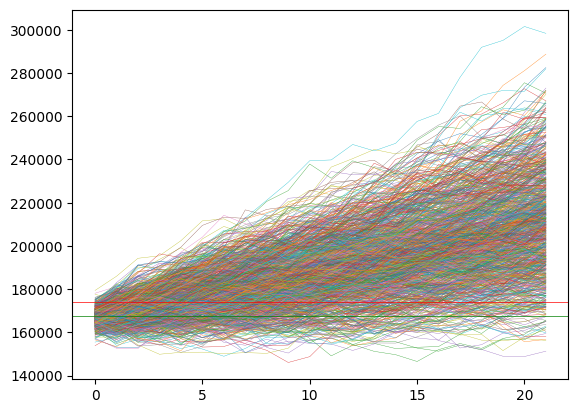

In [ ]:
# -------------------------------
# Cálculo do VaR e CVaR
# -------------------------------
alpha = 5

def montecarlo_var(alpha):
    """Calcula o VaR usando a simulação de Monte Carlo."""
    sim_val = simulated_portfolio.iloc[-1, :]  # Valores finais do portfólio
    return np.percentile(sim_val, alpha)  # Calcula o percentil alfa para o VaR

def conditional_var(alpha):
    """Calcula o CVaR usando a simulação de Monte Carlo."""
    sim_val = simulated_portfolio.iloc[-1, :]  # Valores finais do portfólio
    return sim_val[sim_val <= montecarlo_var(alpha)].mean()  # Calcula a média das perdas que excedem o VaR

# Calcular métricas de risco
mc_var = montecarlo_var(alpha)
mc_cond_var = conditional_var(alpha)

# -------------------------------
# Visualizar os Resultados
# -------------------------------
ax = simulated_portfolio.plot(lw=0.25, legend=False)
ax.axhline(mc_var, lw=0.5, c='r', label=f"VaR ({alpha}%)")
ax.axhline(mc_cond_var, lw=0.5, c='g', label=f"CVaR ({alpha}%)")
plt.show()

In [ ]:
print(f"VaR ({alpha}%): {mc_var:.2f}")
print(f"CVaR ({alpha}%): {mc_cond_var:.2f}")

VaR (5%): 173868.77
CVaR (5%): 167723.13
